In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .config("spark.memory.offHeap.enabled","true")
    .config("spark.memory.offHeap.size","12g")
    .getOrCreate()
)

spark.conf.set("spark.sql.shuffle.partitions", 10000)

your 131072x1 screen size is bogus. expect trouble
24/10/06 00:33:51 WARN Utils: Your hostname, LAPTOP-1A92TAQQ resolves to a loopback address: 127.0.1.1; using 172.18.166.45 instead (on interface eth0)
24/10/06 00:33:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/06 00:33:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/06 00:33:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
trans_sdf = spark.read.parquet("../data/merged/merged_transactions_with_tags.parquet")
print(trans_sdf.count())
trans_sdf.show(5, truncate=False) 

24/10/06 00:34:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


13614854


+---------------------------------------------------------+-------+------------+------------------+------------------------------------+--------------+-------------------------+-----------+--------------+---------------------------+-----+--------+------+--------------------------+--------------------------+--------------------+------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------+------------+--------------------+--------------------------+--------------------+--------+------------+---------+----------------+
|description           

In [3]:
from pyspark.sql.window import Window

# Define window spec based on merchant and order time
window_spec = Window.partitionBy('merchant_abn').orderBy('order_datetime').rowsBetween(Window.unboundedPreceding, Window.currentRow)
prev_window_spec = Window.partitionBy('merchant_abn').orderBy('order_datetime').rowsBetween(Window.unboundedPreceding, -1)

customer_count = trans_sdf.select("merchant_abn", "consumer_id", "order_datetime")

customer_count.cache()

customer_count = customer_count.withColumn('cumulative_customers', 
                                           F.collect_set('consumer_id').over(window_spec))

customer_count = customer_count.withColumn('previous_cumulative_customers', 
                                           F.collect_set('consumer_id').over(prev_window_spec))

customer_count = customer_count.withColumn('new_unique_customers', 
                                           F.expr("array_except(cumulative_customers, previous_cumulative_customers)"))

customer_count = customer_count.withColumn('num_new_unique_customers', 
                                           F.size('new_unique_customers'))

customer_count = customer_count.withColumn('num_cumulative_customers', 
                                           F.size('cumulative_customers'))

customer_count = customer_count.orderBy("merchant_abn", "order_datetime")

customer_count = customer_count.select("merchant_abn", "order_datetime", "num_cumulative_customers", "num_new_unique_customers")

customer_count.show(5, truncate=False)

+------------+--------------+------------------------+------------------------+
|merchant_abn|order_datetime|num_cumulative_customers|num_new_unique_customers|
+------------+--------------+------------------------+------------------------+
|10023283211 |2021-02-28    |1                       |1                       |
|10023283211 |2021-02-28    |2                       |1                       |
|10023283211 |2021-02-28    |3                       |1                       |
|10023283211 |2021-03-01    |4                       |1                       |
|10023283211 |2021-03-01    |5                       |1                       |
+------------+--------------+------------------------+------------------------+
only showing top 5 rows



In [4]:
unique_customer_count = trans_sdf.groupBy("merchant_abn").agg(F.countDistinct("consumer_id").alias("unique_consumer_count"))
print(unique_customer_count.count())
unique_customer_count.show(5, truncate=False)

4026


+------------+---------------------+
|merchant_abn|unique_consumer_count|
+------------+---------------------+
|96946925998 |131                  |
|18525353549 |890                  |
|68289707002 |2242                 |
|60616659469 |507                  |
|42735118354 |444                  |
+------------+---------------------+
only showing top 5 rows



In [5]:
sorted_df = unique_customer_count.orderBy(unique_customer_count['unique_consumer_count'].desc())
merchants_list = sorted_df.select("merchant_abn").distinct().rdd.flatMap(lambda x: x).collect()

In [6]:
# for merchant in merchants_list:
#     i += 1
#     print(i)
#     print(merchant)
#     customer_df = customer_count.filter(F.col("merchant_abn") == merchant).groupBy('merchant_abn', 'order_datetime') \
#         .agg(
#             F.max('num_cumulative_customers').alias('total_cumulative_customers'), 
#             F.sum('num_new_unique_customers').alias('total_new_unique_customers')
#         ) 
    
#     output_path = f"../data/customer/{merchant}_customer_data.parquet"  
    
#     customer_df.write.mode("overwrite").parquet(output_path)
    
#     print(f"Data for merchant {merchant} saved to {output_path}")

# Feature Engineering
- Calculate the number of unique customers that come in everyday

### Goal: Model a Time Series Model for the unique customers that come in for every merchant AKA the growth in customers for every merchant
- Modelling cumulative unique customers through the period of the transactions and forecasting for the next 6 months
- Dependent Variables: Cumulative Unique Customers

### Creating a model for  a single merchant

In [7]:
merchant_abn = 46804135891
merchant_df = spark.read.parquet(f"../data/customer/{merchant_abn}_customer_data.parquet")

print("Number of entries =", merchant_df.count())
merchant_df.show(5, truncate = False)

Number of entries = 606
+------------+--------------+--------------------------+--------------------------+
|merchant_abn|order_datetime|total_cumulative_customers|total_new_unique_customers|
+------------+--------------+--------------------------+--------------------------+
|46804135891 |2021-02-28    |303                       |303                       |
|46804135891 |2021-03-01    |535                       |232                       |
|46804135891 |2021-03-02    |781                       |246                       |
|46804135891 |2021-03-03    |1061                      |280                       |
|46804135891 |2021-03-04    |1294                      |233                       |
+------------+--------------+--------------------------+--------------------------+
only showing top 5 rows



In [8]:
merchant_df = merchant_df.withColumn('order_datetime', F.col('order_datetime').cast('date'))
first_date = merchant_df.agg(F.min('order_datetime')).collect()[0][0]

merchant_df = merchant_df.withColumn('days_since_first_record', F.datediff(F.col('order_datetime'), F.lit(first_date)))
merchant_df = merchant_df.withColumn('days_since_first_record_2', F.pow(F.col('days_since_first_record'), 2))
merchant_df.show(5, truncate=False)

+------------+--------------+--------------------------+--------------------------+-----------------------+-------------------------+
|merchant_abn|order_datetime|total_cumulative_customers|total_new_unique_customers|days_since_first_record|days_since_first_record_2|
+------------+--------------+--------------------------+--------------------------+-----------------------+-------------------------+
|46804135891 |2021-02-28    |303                       |303                       |0                      |0.0                      |
|46804135891 |2021-03-01    |535                       |232                       |1                      |1.0                      |
|46804135891 |2021-03-02    |781                       |246                       |2                      |4.0                      |
|46804135891 |2021-03-03    |1061                      |280                       |3                      |9.0                      |
|46804135891 |2021-03-04    |1294                      |233   

In [9]:
# Split into training and test df
split_point = int(merchant_df.count() * 0.8)

train_data = merchant_df.limit(split_point)
test_data = merchant_df.subtract(train_data).orderBy('order_datetime')

### LASSO Linear Regression Model

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

feature_columns = ['days_since_first_record',
                   'days_since_first_record_2']

assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')

lasso = LinearRegression(featuresCol = 'features', 
                         labelCol = 'total_cumulative_customers',
                         maxIter = 50,
                         elasticNetParam = 1.0, 
                         regParam = 1.0,
                         standardization = True,
                         loss = 'squaredError')

pipeline = Pipeline(stages = [assembler, lasso])

lasso_model = pipeline.fit(train_data)

train_pred = lasso_model.transform(train_data)
test_pred = lasso_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol = 'total_cumulative_customers', predictionCol = 'prediction', metricName = 'rmse')

print('Training RMSE =', evaluator.evaluate(train_pred))
print('Testing RMSE =', evaluator.evaluate(test_pred))

24/10/06 00:34:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Training RMSE = 1496.1042114160027
Testing RMSE = 6580.436998319622


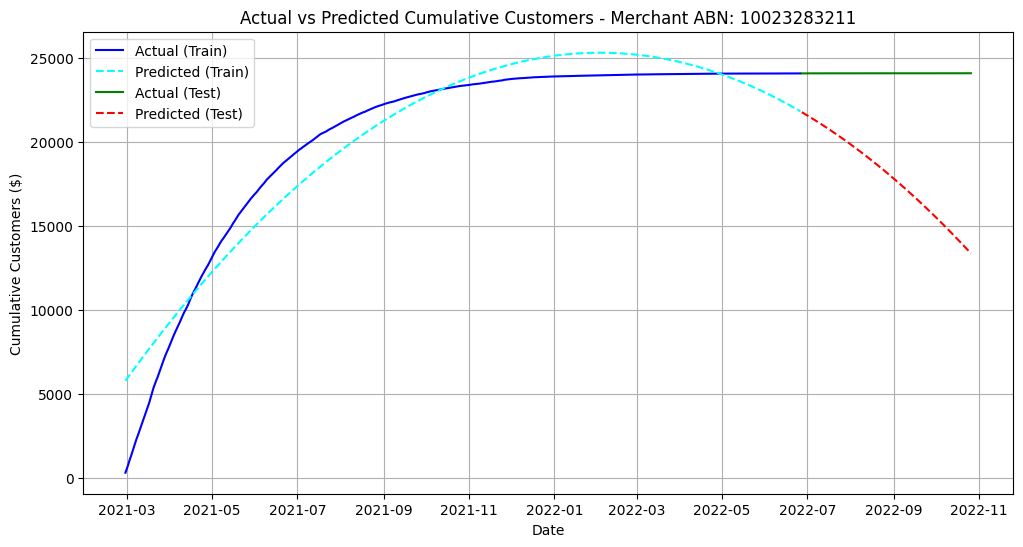

In [11]:
import matplotlib.pyplot as plt

train_pd = train_pred.select('order_datetime', 'total_cumulative_customers', 'prediction').toPandas()
test_pd = test_pred.select('order_datetime', 'total_cumulative_customers', 'prediction').toPandas()

plt.figure(figsize = (12, 6))

plt.plot(train_pd['order_datetime'], train_pd['total_cumulative_customers'], label = 'Actual (Train)', color = 'blue')
plt.plot(train_pd['order_datetime'], train_pd['prediction'], label = 'Predicted (Train)', color = 'cyan', linestyle = '--')

plt.plot(test_pd['order_datetime'], test_pd['total_cumulative_customers'], label = 'Actual (Test)', color = 'green')
plt.plot(test_pd['order_datetime'], test_pd['prediction'], label = 'Predicted (Test)', color = 'red', linestyle = '--')

plt.xlabel('Date')
plt.ylabel('Cumulative Customers ($)')
plt.title('Actual vs Predicted Cumulative Customers - Merchant ABN: 10023283211')
plt.legend()
plt.grid(True)
plt.show()

### SARIMAX

In [12]:
import pandas as pd

# Make predictions
train_pred = lasso_model.transform(train_data)
test_pred = lasso_model.transform(test_data)

train_pred_pd = train_pred.select('total_cumulative_customers', 'prediction', 'order_datetime').toPandas()
test_pred_pd = test_pred.select('total_cumulative_customers', 'prediction', 'order_datetime').toPandas()

merchant_pd = pd.concat([train_pred_pd, test_pred_pd])

merchant_pd['order_datetime'] = pd.to_datetime(merchant_pd['order_datetime'])
merchant_pd.set_index('order_datetime', inplace = True)

full_range = pd.date_range(start = merchant_pd.index.min(), end = merchant_pd.index.max(), freq = 'D')
merchant_pd = merchant_pd.reindex(full_range).fillna(0) 

- Using predicted values of the Lasso Linear Regression
- Log Transform using log (1 + value) so it does not give a negative value

/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'fopt': np.float64(-8.559593971185969), 'gopt': array([   19.1181028 ,   -89.37055078,    68.82034135,   -68.96804757,
       17468.09204486]), 'fcalls': 330, 'warnflag': 2, 'converged': False, 'iterations': 2}


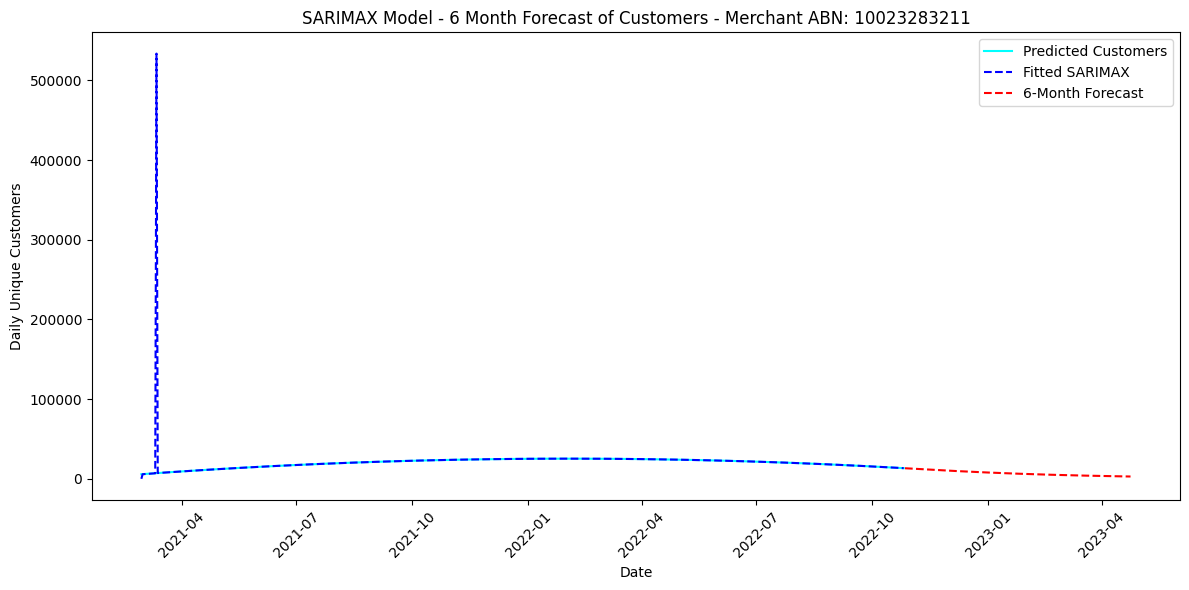

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

time_series_data = merchant_pd['prediction']
time_series_data_log = np.log1p(merchant_pd['prediction'])

model = SARIMAX(time_series_data_log, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12), freq = "D")
fitted_model = model.fit(maxiter = 500, disp = False)
print(fitted_model.mle_retvals)

in_sample_predictions_log = fitted_model.fittedvalues

forecast_steps = 180
forecast_log = fitted_model.forecast(steps = forecast_steps)

in_sample_predictions = np.expm1(in_sample_predictions_log)
forecast = np.expm1(forecast_log)

last_date = time_series_data_log.index[-1]
forecast_index = pd.date_range(start = last_date + pd.DateOffset(days = 1), periods = forecast_steps, freq = 'D')
forecast_series = pd.Series(forecast, index = forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Predicted Customers', color='cyan')
plt.plot(in_sample_predictions.index, in_sample_predictions, label='Fitted SARIMAX', color='blue', linestyle='--')
plt.plot(forecast_series.index, forecast_series, label='6-Month Forecast', color='red', linestyle='--')

plt.title('SARIMAX Model - 6 Month Forecast of Customers - Merchant ABN: 10023283211')
plt.xlabel('Date')
plt.ylabel('Daily Unique Customers')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'fopt': np.float64(-3.0464281478023474), 'gopt': array([1.10066995, 1.4624098 , 0.69841735, 1.39775365, 1.05736761]), 'fcalls': 726, 'warnflag': 2, 'converged': False, 'iterations': 22}


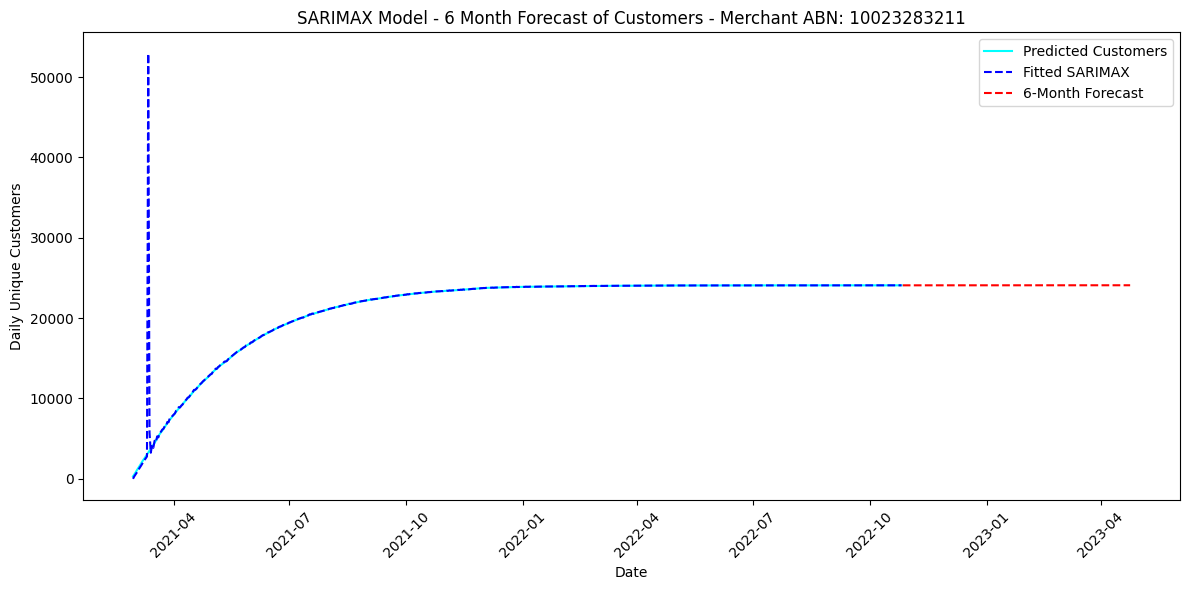

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

time_series_data = merchant_pd['total_cumulative_customers']
time_series_data_log = np.log1p(merchant_pd['total_cumulative_customers'])

model = SARIMAX(time_series_data_log, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12), freq = "D")
fitted_model = model.fit(maxiter = 500, disp = False)
print(fitted_model.mle_retvals)

in_sample_predictions_log = fitted_model.fittedvalues

forecast_steps = 180
forecast_log = fitted_model.forecast(steps = forecast_steps)

in_sample_predictions = np.expm1(in_sample_predictions_log)
forecast = np.expm1(forecast_log)

last_date = time_series_data_log.index[-1]
forecast_index = pd.date_range(start = last_date + pd.DateOffset(days = 1), periods = forecast_steps, freq = 'D')
forecast_series = pd.Series(forecast, index = forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Predicted Customers', color='cyan')
plt.plot(in_sample_predictions.index, in_sample_predictions, label='Fitted SARIMAX', color='blue', linestyle='--')
plt.plot(forecast_series.index, forecast_series, label='6-Month Forecast', color='red', linestyle='--')

plt.title('SARIMAX Model - 6 Month Forecast of Customers - Merchant ABN: 10023283211')
plt.xlabel('Date')
plt.ylabel('Daily Unique Customers')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Looping over all the merchants

In [15]:
def get_merchant_data(merchant_abn):
    merchant_df = spark.read.parquet(f"../data/customer/{merchant_abn}_customer_data.parquet")

    # Too few transactions -> need to look at manually?
    if merchant_df.count() <= 20:
        # Print 'Error' information
        print('Error handling merchant ABN =', merchant_abn)
        print(f'Too few DAYS WITH TRANSACTIONS (days = {merchant_df.count()})')
        return None

    return merchant_df

In [16]:
import pandas as pd

# Creates a (pandas) train-test split for data from a single merchant
def create_train_test_split(data, split_date = '2022-06-28'):
    # Convert to pandas
    data_pd = data.select('order_datetime', 'total_cumulative_customers').toPandas()

    data_pd['order_datetime'] = pd.to_datetime(data_pd['order_datetime'])
    data_pd.set_index('order_datetime', inplace = True)
    
    full_range = pd.date_range(start = data_pd.index.min(), end = data_pd.index.max(), freq = 'D')
    
    # Missing day -> cumulative revenue = previous cumulative revenue
    data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')

    # Train-test split based on split_date
    train_pd = data_pd[data_pd.index < split_date]
    test_pd = data_pd[data_pd.index >= split_date]

    return train_pd, test_pd

In [17]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, LongType, DoubleType, TimestampType

def append_to_forecast_df(merchant_abn, train_pd, in_sample_predictions, forecast_test, forecast_to_end, 
                          forecast_df):
    # forecast_df has a date range from 2021-02-28 to 2023-05-01
    date_range = pd.date_range(start = '2021-02-28', end = '2023-05-01')

    # Fill in values before the first training date with 0
    first_train_date = train_pd.index[0]
    pre_train_dates = pd.date_range(start='2021-02-28', end = first_train_date - pd.DateOffset(days=1))
    pre_train_values = [0.0] * len(pre_train_dates)

    # Collect the fitted values for training data
    train_values = in_sample_predictions.tolist()
    # Collect the forecast values for test data
    test_forecast_values = forecast_test.tolist()
    # Collect forecast values until 2023-05-01
    forecast_values_to_end = forecast_to_end.tolist()

    # Combine all dates and values into a dictionary
    all_forecast_values = pre_train_values + train_values + test_forecast_values + forecast_values_to_end
    forecast_dict = {'merchant_abn': merchant_abn}
    for date, value in zip(date_range, all_forecast_values):
        forecast_dict[date.strftime('%Y-%m-%d')] = value
    # Convert dictionary into a list of rows for Spark df
    forecast_row = [Row(**forecast_dict)]

    # Create Spark df with the provided schema
    schema_fields = [StructField('merchant_abn', LongType(), True)] + \
                    [StructField(date.strftime('%Y-%m-%d'), DoubleType(), True) for date in date_range]
    schema = StructType(schema_fields)
    forecast_row_df = spark.createDataFrame(forecast_row, schema)

    # Append row to the forecast_df
    forecast_df = forecast_df.union(forecast_row_df)

    return forecast_df

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pyspark.sql import Row

def SARIMAX_model(merchant_abn, train_pd, test_pd, forecast_df, summary_df, plot):
    
    time_series_data = train_pd['total_cumulative_customers']


    ###
    # Model fitting + forecasting
    # Fit the SARIMAX model
    model = SARIMAX(time_series_data, order = (1, 1, 1), seasonal_order = (1, 1, 1, 7), freq = 'D')
    fitted_model = model.fit(maxiter = 500, disp = False)

    # Get fitted values
    in_sample_predictions = fitted_model.fittedvalues

    # Forecast test data (from last date of training data to last entry of testing data)
    last_train_date = train_pd.index[-1]
    last_test_date = test_pd.index[-1]
    forecast_steps = (last_test_date - last_train_date).days
    forecast_test = fitted_model.forecast(steps = forecast_steps)

    # Forecast to 2023-05-01 (~ 6 months after last transactions)
    forecast_end_date = pd.Timestamp('2023-05-01')
    forecast_period_days = (forecast_end_date - last_train_date).days
    forecast_to_end = fitted_model.forecast(steps = forecast_period_days)
    ###


    ###
    # RMSE calculations
    rmse_train = np.sqrt(mean_squared_error(time_series_data, in_sample_predictions))
    rmse_test = np.sqrt(mean_squared_error(test_pd['total_cumulative_customers'], forecast_test))
    # Append RMSE summary to summary_df
    new_row = Row(merchant_abn = merchant_abn, RMSE_train = float(rmse_train), RMSE_test = float(rmse_test))
    new_row_df = spark.createDataFrame([new_row])
    summary_df = summary_df.union(new_row_df)
    ###
    

    ###
    # Append forecasts to forecasts_df
    forecast_df = append_to_forecast_df(merchant_abn, train_pd, in_sample_predictions, forecast_test, forecast_to_end, forecast_df)
    ###


    ###
    # Plotting
    if plot:
        plt.figure(figsize = (18, 8))
        plt.plot(time_series_data.index, time_series_data, label = 'Actual Cumulative Customerse (Train)', color = 'cyan')
        plt.plot(in_sample_predictions.index, in_sample_predictions, label = 'Fitted SARIMAX (Train)', color = 'blue', linestyle = '--')
        plt.plot(test_pd.index, test_pd['total_cumulative_customers'], label = 'Actual Cumulative Customers (Test)', color = 'lime')
        plt.plot(test_pd.index, forecast_test, label = 'Forecast Cumulative Customers (Test)', color = 'red', linestyle = '--')
        plt.plot(forecast_to_end.index, forecast_to_end, label = '6 Month Cumulative Customers Forecast', color = 'purple', linestyle = '--')

        # Title and axis labels
        plt.title(f'SARIMAX Model - Forecast of Cumulative Customers - Merchant ABN: {merchant_abn}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Revenue ($)')
        plt.legend()

        plt.xticks(rotation = 45)
        plt.tight_layout()
        plt.show()

        # Print RMSE stats
        print("Training RMSE =", rmse_train)
        print("Testing_RMSE =", rmse_test)
    ###
        
    return forecast_df, summary_df

In [19]:
# Run 1 model and store forecasts / RMSE statistics in datasets
def model_pipeline(merchant_abn, forecast_df, summary_df, plot):
    # Get the df for the specific merchant
    merchant_df = get_merchant_data(merchant_abn)
    
    # merchant_df did not have enough days with transactions
    if not merchant_df:
        return forecast_df, summary_df

    # Create train-test split and run the SARIMAX model
    train_pd, test_pd = create_train_test_split(merchant_df)
    forecast_df, summary_df = SARIMAX_model(merchant_abn, train_pd, test_pd, forecast_df, summary_df, plot)

    return forecast_df, summary_df

In [28]:
import os

# Function for saving dataframes into individual folders
def save_df_as_parquet(merchant_abn, forecast_df, summary_df, base_folder = '../data/customer_model_output'):
    # Create folder path
    folder_name = f"{base_folder}/summary_forecast_{merchant_abn}"
    
    # Create folder if it does not exist
    os.makedirs(folder_name, exist_ok = True)

    # Define paths for the Parquets
    summary_path = os.path.join(folder_name, 'summary.parquet')
    forecast_path = os.path.join(folder_name, 'forecast.parquet')

    # Save dfs
    summary_df.write.mode('overwrite').parquet(summary_path)
    forecast_df.write.mode('overwrite').parquet(forecast_path)

    print(f"Saved summary_df to {summary_path}")
    print(f"Saved forecast_df to {forecast_path}")

In [29]:
from pyspark.sql.types import StructType, StructField, LongType, DoubleType

def run_merchant_models(start_index, end_index, abn_list, plot = False):
    # Create dfs for storing forecasts and RMSE stats
    # RMSE stats
    schema = StructType([StructField('merchant_abn', LongType(), True),
                         StructField('RMSE_train', DoubleType(), True),
                         StructField('RMSE_test', DoubleType(), True)
                         ])
    summary_df = spark.createDataFrame([], schema)

    # Forecasts
    date_range = pd.date_range(start = '2021-02-28', end = '2023-05-01')
    schema_fields = [StructField('merchant_abn', LongType(), True)] + \
                    [StructField(date.strftime('%Y-%m-%d'), DoubleType(), True) for date in date_range]
    schema = StructType(schema_fields)
    forecast_df = spark.createDataFrame([], schema)

    # Track index
    i = 0
    # Run model for all merchant_abns in range
    for merchant_abn in abn_list[start_index : end_index]:
        # Track index for error handling
        print(f'Starting index {start_index + i}...')
        i += 1

        # Model
        forecast_df, summary_df = model_pipeline(merchant_abn, forecast_df, summary_df, plot)
    
        # Save dfs
        save_df_as_parquet(merchant_abn, forecast_df, summary_df)

In [30]:
merchants_list = sorted(merchants_list)

In [35]:
run_merchant_models(4, 4027, merchants_list, plot=False)

Starting index 4...


/tmp/ipykernel_131353/3238823766.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Saved summary_df to ../data/customer_model_output/summary_forecast_10192359162/summary.parquet
Saved forecast_df to ../data/customer_model_output/summary_forecast_10192359162/forecast.parquet
Starting index 5...


/tmp/ipykernel_131353/3238823766.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/tmp/ipykernel_131353/3238823766.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Saved summary_df to ../data/customer_model_output/summary_forecast_10206519221/summary.parquet
Saved forecast_df to ../data/customer_model_output/summary_forecast_10206519221/forecast.parquet
Starting index 6...


/tmp/ipykernel_131353/3238823766.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Saved summary_df to ../data/customer_model_output/summary_forecast_10255988167/summary.parquet
Saved forecast_df to ../data/customer_model_output/summary_forecast_10255988167/forecast.parquet
Starting index 7...


Saved summary_df to ../data/customer_model_output/summary_forecast_10264435225/summary.parquet
Saved forecast_df to ../data/customer_model_output/summary_forecast_10264435225/forecast.parquet
Starting index 8...


/tmp/ipykernel_131353/3238823766.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


KeyboardInterrupt: 